In [ ]:
!pip install -qU malariagen_data

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.0/4.0 MB 21.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 195.4/195.4 kB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 71.7/71.7 kB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 775.9/775.9 kB 38.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 25.9/25.9 MB 44.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.7/8.7 MB 85.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.3/211.3 kB 15.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.3/6.3 MB 70.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 66.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.9/7.9 MB 72.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.3/78.3 kB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.7/101.

In [ ]:
import allel
import malariagen_data
import itertools
import numpy as np
import pandas as pd
pd.set_option("display.max_rows", None, "display.max_columns", None)
#pd.reset_option('^display.', silent=True)
import functools
#import dask
from dask.diagnostics.progress import ProgressBar
#dask.config.set(**{'array.slicing.split_large_chunks': True})
import warnings
warnings.filterwarnings("ignore")

In [ ]:
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from matplotlib.patches import Patch
from matplotlib.lines import Line2D
from matplotlib.gridspec import GridSpec
import matplotlib.gridspec as gridspec
#import matplotlib_venn as venn
%matplotlib inline
%config InlineBackend.figure_format = "retina"

In [ ]:
from tqdm.dask import TqdmCallback
from tqdm.auto import tqdm

In [ ]:
#Mounting Google Drive
import os
from google.colab import drive
drive.mount("drive")

# make dir
results_dir = "drive/MyDrive"
os.makedirs(results_dir, exist_ok=True)

Mounted at drive


In [ ]:
ag3 = malariagen_data.Ag3()
ag3

<MalariaGEN Ag3 API client>
Storage URL             : gs://vo_agam_release_master_us_central1/
Data releases available : 3.0, 3.1, 3.2, 3.3, 3.4, 3.5, 3.6, 3.7, 3.8, 3.9, 3.10, 3.11, 3.12, 3.13
Results cache           : None
Cohorts analysis        : 20250131
AIM analysis            : 20220528
Site filters analysis   : dt_20200416
Software version        : malariagen_data 15.0.1
Client location         : South Carolina, United States (Google Cloud us-east1)
---
Please note that data are subject to terms of use,
for more information see https://www.malariagen.net/data
or contact support@malariagen.net. For API documentation see 
https://malariagen.github.io/malariagen-data-python/v15.0.1/Ag3.html

In [ ]:
## access to df_samples sets
sets = ["AG1000G-BF-A", "AG1000G-BF-B", "AG1000G-BF-C", "AG1000G-GH", "AG1000G-GN-A", "AG1000G-GN-B", "AG1000G-MW", "AG1000G-TZ"]
df_samples=ag3.sample_metadata(sample_sets=sets)
#df_samples

## Function to load and compute haplotype stats

In [ ]:
def load_haps(contig, analysis, sample_query, downsample=30, seed=42):

    # access haplotypes
    ds_haps = ag3.haplotypes(region=contig, sample_query=sample_query,
                             sample_sets=sets, analysis=analysis)
    pos = ds_haps["variant_position"].values
    gt = allel.GenotypeDaskArray(ds_haps['call_genotype'].data)

    # downsample haplotypes
    n_samples = ds_haps.dims["samples"]
    if n_samples > downsample:
        np.random.seed(seed)
        ix = np.random.choice(n_samples, size=downsample, replace=False)
        ix.sort()
    gt_cohort = gt.take(ix, axis=1)

    # compute haplotypes and load into memory
    with TqdmCallback(desc="Load haplotypes"):
        ht_cohort = gt_cohort.to_haplotypes().compute()

    return pos, ht_cohort

In [ ]:
@functools.lru_cache(maxsize=None)
def h12_calibration(contig, analysis, sample_query,  window_sizes, downsample=30, seed=42):

    _, ht = load_haps(contig=contig, analysis=analysis, sample_query=sample_query,
                      downsample=downsample, seed=seed)

    calibration_runs = list()
    for window_size in tqdm(window_sizes, desc="Compute H12"):
        h1, h12, h123, h2_h1 = allel.moving_garud_h(ht, size=window_size)
        calibration_runs.append(h12)

    return calibration_runs

In [ ]:
def plot_h12_calibration(contig, analysis, sample_query, window_sizes, downsample=30,
                         seed=42, title=None):

    # get H12 values
    calibration_runs = h12_calibration(contig=contig, analysis=analysis, sample_query=sample_query,
                                       window_sizes=window_sizes, downsample=downsample, seed=seed)

    # compute summaries
    q50 = [np.median(h12) for h12 in calibration_runs]
    q25 = [np.percentile(h12, 25) for h12 in calibration_runs]
    q75 = [np.percentile(h12, 75) for h12 in calibration_runs]
    q05 = [np.percentile(h12, 5) for h12 in calibration_runs]
    q95 = [np.percentile(h12, 95) for h12 in calibration_runs]

    # make a plot
    fig, ax = plt.subplots()
    x = window_sizes
    y = q50
    ax.grid()
    ax.fill_between(x, q05, q95, color='#bbbbff', label="5-95%")
    ax.fill_between(x, q25, q75, color='#7777ff', label="25-75%")
    ax.plot(x, q50, color='k', lw=2, linestyle="-", marker="o", label="median")
    ax.set_xscale("log")
    ax.set_xticks(window_sizes)
    ax.set_xticklabels(window_sizes)
    ax.set_xlabel("Window size (no. SNPs)")
    ax.set_ylabel("H12")
    ax.legend()
    if title is None:
        title = sample_query
    ax.set_title(title)

In [ ]:
@functools.lru_cache(maxsize=None)
def h12_gwss(contig, analysis, sample_query, window_size, downsample=30, seed=42):

    pos, ht = load_haps(contig=contig, analysis=analysis, sample_query=sample_query,
                        downsample=downsample, seed=seed)

    h1, h12, h123, h2_h1 = allel.moving_garud_h(ht, size=window_size)

    hap = allel.moving_haplotype_diversity(ht, size=window_size)

    x = allel.moving_statistic(pos, statistic=np.mean, size=window_size)

    return x, h12, hap

In [ ]:
# Compute the figure of sequence divergence
def fig_h12(x, y, title=None,  ax=None, color=None, ylab=None, xlab=None, fig_name=None):
  #define ax
  if ax is None:
    fig, ax = plt.subplots(figsize=(12, 3))
    sns.despine(ax=ax, offset=5)

  # make plot
  ax.plot(x, y, linestyle=' ', marker='o', color=color, ms=0.5)
  # Plot title
  if title:
    ax.set_title(f'{title}')

  # Customize plot
  if ylab:
    ax.set_ylabel('Garud H12')
  if xlab:
    ax.set_xlabel(f'Chrom {xlab} (bp)')

  #ax setting
  ax.set_ylim(0,1)
  xlim=(list(x)[0], list(x)[-1])
  ax.set_xlim(*xlim)
  ax.set_xticklabels(['{:,}'.format(int(v)) for v in ax.get_xticks()])
  if fig_name:
    fig.savefig(f"drive/MyDrive/analyse_Ki/savefig/H12_{fig_name}.png", dpi=300, bbox_inches='tight')


In [ ]:
# Compute the figure of sequence divergence
def fig_h121(x, y, title=None,  ax=None, color=None, ylab=None, xlab=None, fig_name=None):
  #define ax
  if ax is None:
    fig, ax = plt.subplots(figsize=(14, 4))
    sns.despine(ax=ax, offset=5)

  # make plot
  ax.plot(x, y, linestyle=' ', marker='o', color=color, ms=0.5)
  # Plot title
  if title:
    ax.set_title(f'{title}')

  # Customize plot
  if ylab:
    ax.set_ylabel('H12')
  if xlab:
    ax.set_xlabel(f'Chrom {xlab} (bp)')

  #ax setting
  ax.set_ylim(0,1)
  xlim=(list(x)[0], list(x)[-1])
  ax.set_xlim(*xlim)
  ax.set_xticks([])
  ax.set_xticklabels(['{:,}'.format(int(v)) for v in ax.get_xticks()])


# Sample cohorts
## Define sample cohorts
## Take cohorts with size >= 30 ind

In [ ]:
cohorts, coh30, labels = {}, {}, {}
for co, sp in zip(df_samples.country_iso, df_samples.aim_species):
  country = df_samples.query(f'country_iso=="{co}"').country.unique()[0]
  key = co+"_"+sp
  cohorts[key] = f'country=="{country}" and aim_species=="{sp}"'
  if sp in ['gambiae','coluzzii','arabiensis']:
    labels[key] = f'An. {sp} ({co})'
  else:
    labels[key] = f'{sp[:3]} ({co})'

for coh in cohorts.keys():
  if df_samples.query(f'{cohorts[coh]}').shape[0] >= 30:
    coh30[coh] = cohorts[coh]
#coh30

g_colors = ['dodgerblue','darkturquoise','purple','navy','thistle']
c_colors = ['red','peru',]
a_colors = ['green','olive']

coh30_colors = {
    'BFA_gambiae': g_colors[0],
    'GHA_gambiae': g_colors[1],
    'MLI_gambiae': g_colors[2],
    'GIN_gambiae': g_colors[3],
    'TZA_gambiae': g_colors[4],
    'BFA_coluzzii': c_colors[0],
    'GHA_coluzzii': c_colors[1],
    'MWI_arabiensis': a_colors[0],
    'TZA_arabiensis': a_colors[1],
}

# Callibration of the window sizes

In [ ]:
#for key in coh30.keys():
#  window_sizes = (200, 300, 500, 700, 1000, 2000, 3000, 4000, 5000, 7500, 10000)
#  plot_h12_calibration(contig="2L", analysis="gamb_colu_arab", sample_query=f'{coh30[key]}',
#                       window_sizes=window_sizes)

# compute H12

In [ ]:
## Compute H12 statistics
gh12_dict, pos = {}, {}
for pop in coh30.keys():
  pos[pop], gh12_dict[pop],_ = h12_gwss(contig="2L", analysis="gamb_colu_arab", sample_query=f'{coh30[pop]}',
                                        window_size=2000, downsample=30, seed=42)
# warp to pd.dataframe
gh12_stat = pd.DataFrame(gh12_dict)
gh12_stat.insert(0, 'pos', pos['BFA_gambiae'])
#gh12_stat

In [ ]:
## save h12 data
gh12_stat.to_csv("drive/MyDrive/analyse_Ki/data/h12_gamb_colu_arab.csv")

In [ ]:
## read h12 data
gh12_stat = pd.read_csv("drive/MyDrive/analyse_Ki/data/h12_gamb_colu_arab.csv")

# Plotting H12

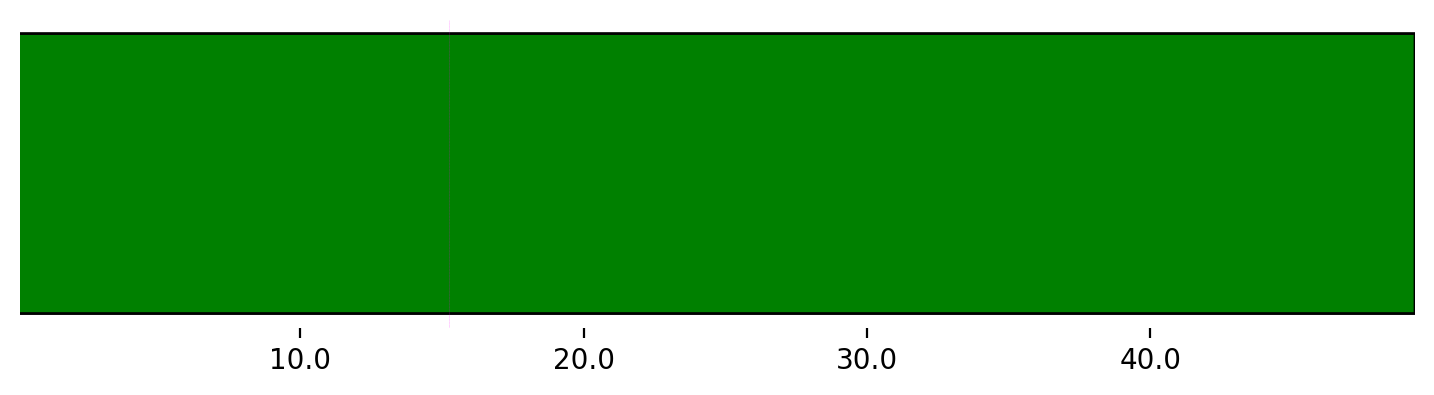

In [ ]:
pos = list(gh12_stat.pos)
def fig_seq (xlim1=pos, xy=(0,0), wh=(pos[-1],0.05),boxstyle=("Round, pad=0.1"),
             facecolor="green", edgecolor=None,ax=None, xlab=None):
  if ax is None:
    fig, ax = plt.subplots(figsize=(9, 2))
  sns.despine(ax=ax, left=True, bottom=True)
  patch = mpl.patches.FancyBboxPatch((xy[0],xy[1]),wh[0],wh[1], boxstyle=boxstyle,
                                     facecolor=facecolor, edgecolor=edgecolor)
  ax.add_patch(patch)
  if xlab:
    ax.set_xlabel(f'{xlab}')

  if xlim1:
    xlim=(list(xlim1)[0], list(xlim1)[-1])
    ax.set_xlim(*xlim)
    ax.set_yticks([])
    ax.set_xticklabels(['{:,}'.format(int(x)/1000000) for x in ax.get_xticks()])
    ax.autoscale(axis='y', tight=False)
fig_seq()
plt.axvspan(15240572, 15242864, color='magenta', alpha=0.2, ls='--', lw=0.2)

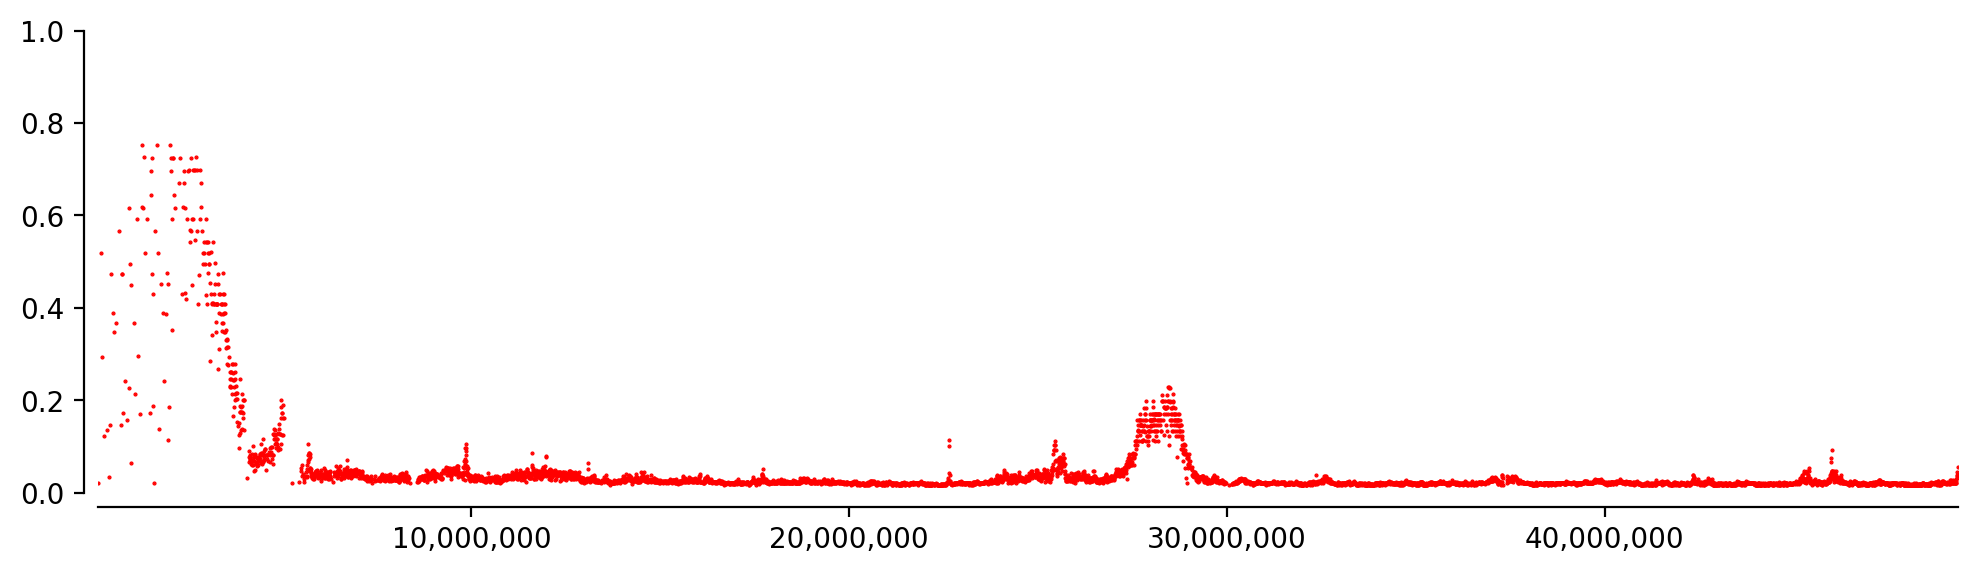

In [ ]:
fig_h12(x=gh12_stat.pos, y=gh12_stat.BFA_gambiae, color='red')

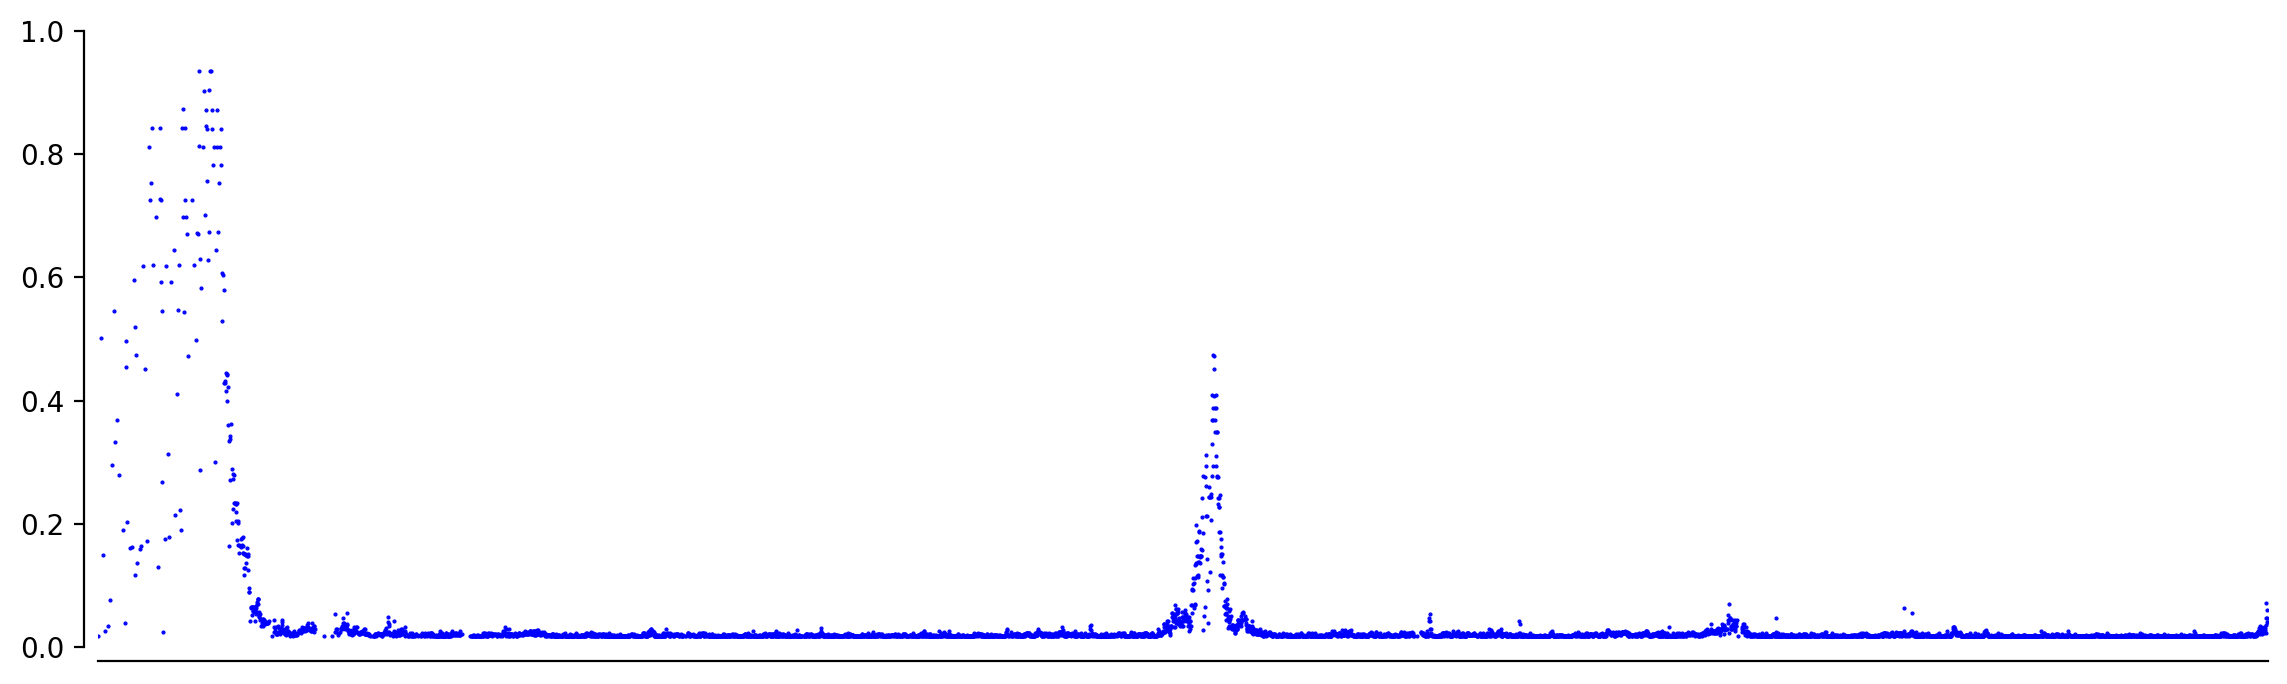

In [ ]:
fig_h121(x=gh12_stat.pos, y=gh12_stat.BFA_coluzzii, color='blue')

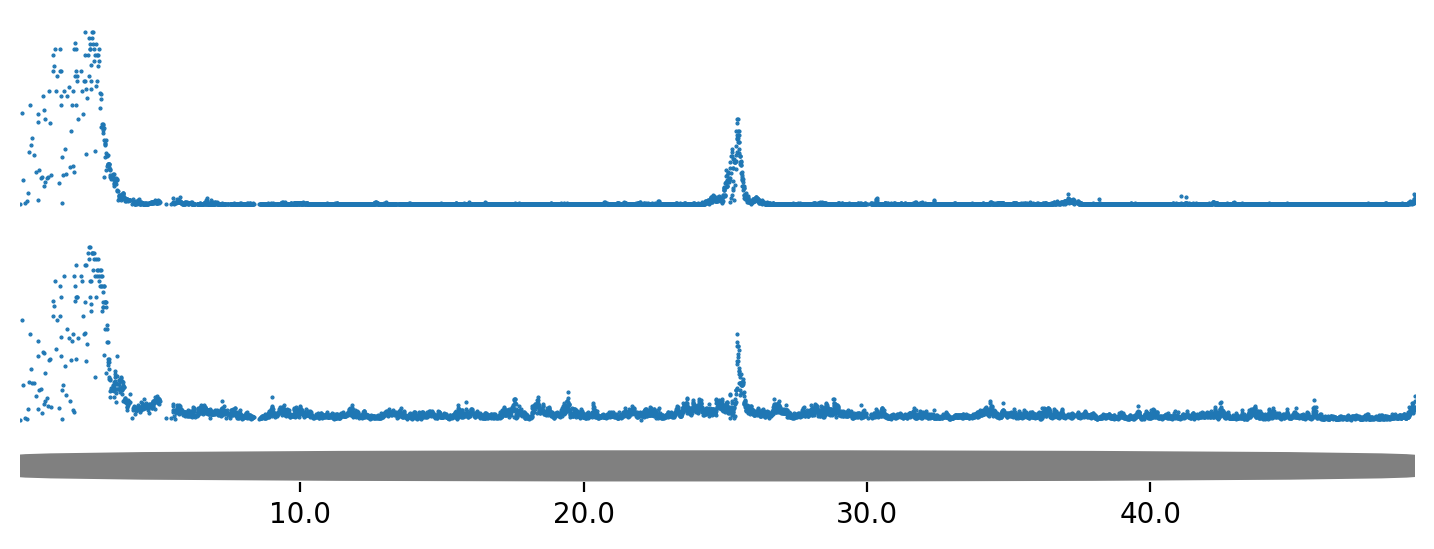

In [ ]:
### multiples plots - test
gs = plt.GridSpec(nrows=3, ncols=1, height_ratios=(3,3,0.5))
fig = plt.figure(figsize=(9,3))
ax = fig.add_subplot(gs[0])
fig_h121(gh12_stat.pos, gh12_stat.BFA_coluzzii, ax=ax, ylab=True)
plt.axis('off')
ax = fig.add_subplot(gs[1])
fig_h121(gh12_stat.pos, gh12_stat.GHA_coluzzii, ax=ax, ylab=True)
plt.axis('off')
ax = fig.add_subplot(gs[2])
fig_seq(xlim1=pos,xy=(0,0), wh=(pos[-1],0.05),boxstyle=("Round4, pad=0.1"), ax=ax,facecolor='gray', edgecolor='gray')


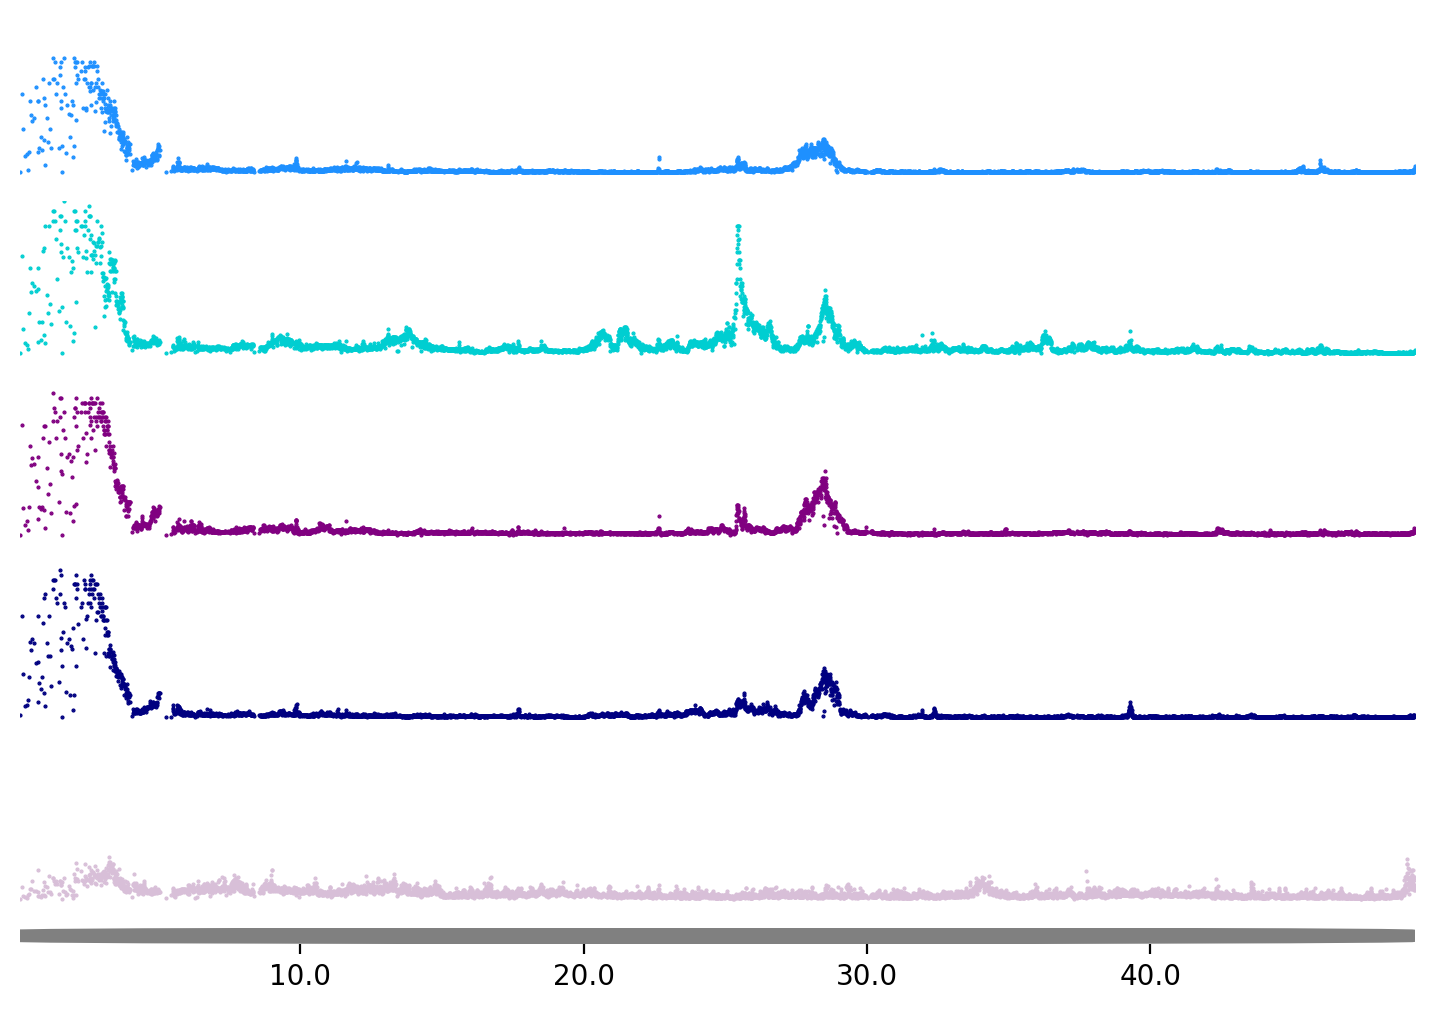

In [ ]:
### multiples plots - test
gs = plt.GridSpec(nrows=6, ncols=1, height_ratios=(2,2,2,2,2,0.20))
fig = plt.figure(figsize=(9,6))
ax = fig.add_subplot(gs[0])
fig_h121(gh12_stat.pos, gh12_stat.BFA_gambiae, color=g_colors[0], ax=ax, ylab=True)
plt.axis('off')
ax = fig.add_subplot(gs[1])
fig_h121(gh12_stat.pos, gh12_stat.GHA_gambiae,color=g_colors[1], ax=ax, ylab=True)
plt.axis('off')
ax = fig.add_subplot(gs[2])
fig_h121(gh12_stat.pos, gh12_stat.MLI_gambiae, color=g_colors[2], ax=ax, ylab=True)
plt.axis('off')
ax = fig.add_subplot(gs[3])
fig_h121(gh12_stat.pos, gh12_stat.GIN_gambiae, color=g_colors[3], ax=ax, ylab=True)
plt.axis('off')
ax = fig.add_subplot(gs[4])
fig_h121(gh12_stat.pos, gh12_stat.TZA_gambiae, color=g_colors[4], ax=ax, ylab=True)
plt.axis('off')
ax = fig.add_subplot(gs[5])
fig_seq(xlim1=pos,xy=(0,0), wh=(pos[-1],0.05),boxstyle=("Round4, pad=0.1"), ax=ax,facecolor='gray', edgecolor='gray')


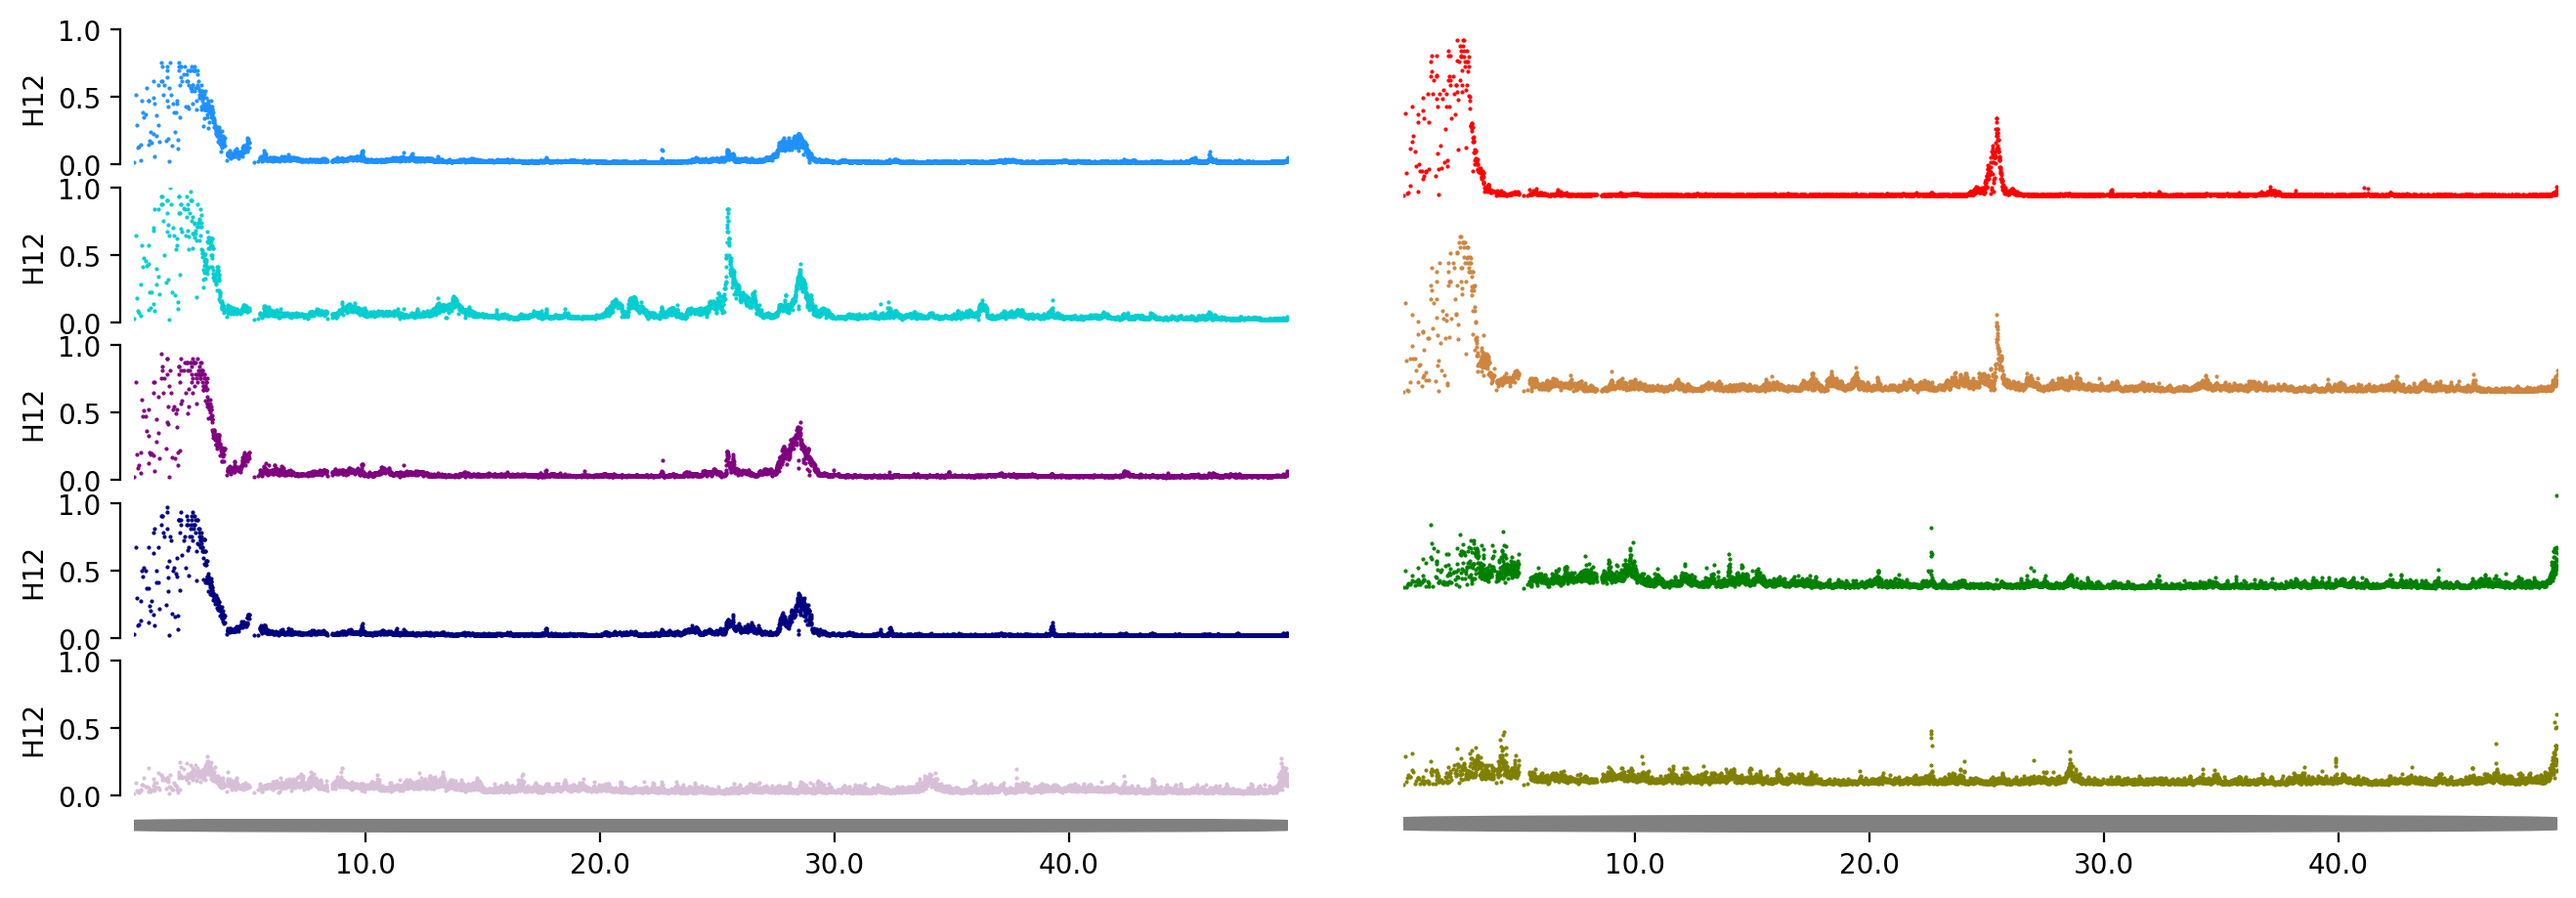

In [ ]:
fig = plt.figure(figsize=(16,12))
gs0 = gridspec.GridSpec(2, 2, wspace=0.1, hspace=0.25)

gs00 = gridspec.GridSpecFromSubplotSpec(6, 1, subplot_spec=gs0[0],height_ratios=(2,2,2,2,2,0.20))
ax1 = fig.add_subplot(gs00[0, 0])
sns.despine(ax=ax1, bottom=True, top = True, offset=5)
fig_h121(gh12_stat.pos, gh12_stat.BFA_gambiae, color=g_colors[0], ax=ax1, ylab=True)
#plt.axis('off')

ax2 = fig.add_subplot(gs00[1, 0])
sns.despine(ax=ax2, bottom=True, top = True, offset=5)
fig_h121(gh12_stat.pos, gh12_stat.GHA_gambiae,color=g_colors[1], ax=ax2, ylab=True)
#plt.axis('off')

ax3 = fig.add_subplot(gs00[2, 0])
sns.despine(ax=ax3, bottom=True, top = True, offset=5)
fig_h121(gh12_stat.pos, gh12_stat.MLI_gambiae, color=g_colors[2], ax=ax3, ylab=True)
#plt.axis('off')

ax4 = fig.add_subplot(gs00[3, 0])
sns.despine(ax=ax4, bottom=True, top = True, offset=5)
fig_h121(gh12_stat.pos, gh12_stat.GIN_gambiae, color=g_colors[3], ax=ax4, ylab=True)
#plt.axis('off')

ax5 = fig.add_subplot(gs00[4, 0])
sns.despine(ax=ax5, bottom=True, top = True, offset=5)
fig_h121(gh12_stat.pos, gh12_stat.TZA_gambiae, color=g_colors[4], ax=ax5, ylab=True)
#plt.axis('off')

ax6 = fig.add_subplot(gs00[5, 0])
fig_seq(xlim1=pos,xy=(0,0), wh=(pos[-1],0.05),boxstyle=("Round4, pad=0.1"), ax=ax6,facecolor='gray', edgecolor='gray')

####
gs01 = gridspec.GridSpecFromSubplotSpec(5, 1, subplot_spec=gs0[1],height_ratios=(2,2,2,2,0.2))

ax1 = fig.add_subplot(gs01[0, 0])
fig_h121(gh12_stat.pos, gh12_stat.BFA_coluzzii, color=c_colors[0], ax=ax1, ylab=True)
plt.axis('off')

ax2 = fig.add_subplot(gs01[1, 0])
fig_h121(gh12_stat.pos, gh12_stat.GHA_coluzzii,color=c_colors[1], ax=ax2, ylab=True)
plt.axis('off')

ax3 = fig.add_subplot(gs01[2, 0])
fig_h121(gh12_stat.pos, gh12_stat.MWI_arabiensis, color=a_colors[0], ax=ax3, ylab=True)
plt.axis('off')

ax3 = fig.add_subplot(gs01[3, 0])
fig_h121(gh12_stat.pos, gh12_stat.TZA_arabiensis, color=a_colors[1], ax=ax3, ylab=True)
plt.axis('off')

ax4 = fig.add_subplot(gs01[4, 0])
fig_seq(xlim1=pos,xy=(0,0), wh=(pos[-1],0.05),boxstyle=("Round4, pad=0.1"), ax=ax4,facecolor='gray', edgecolor='gray')
#plt.axis('off')

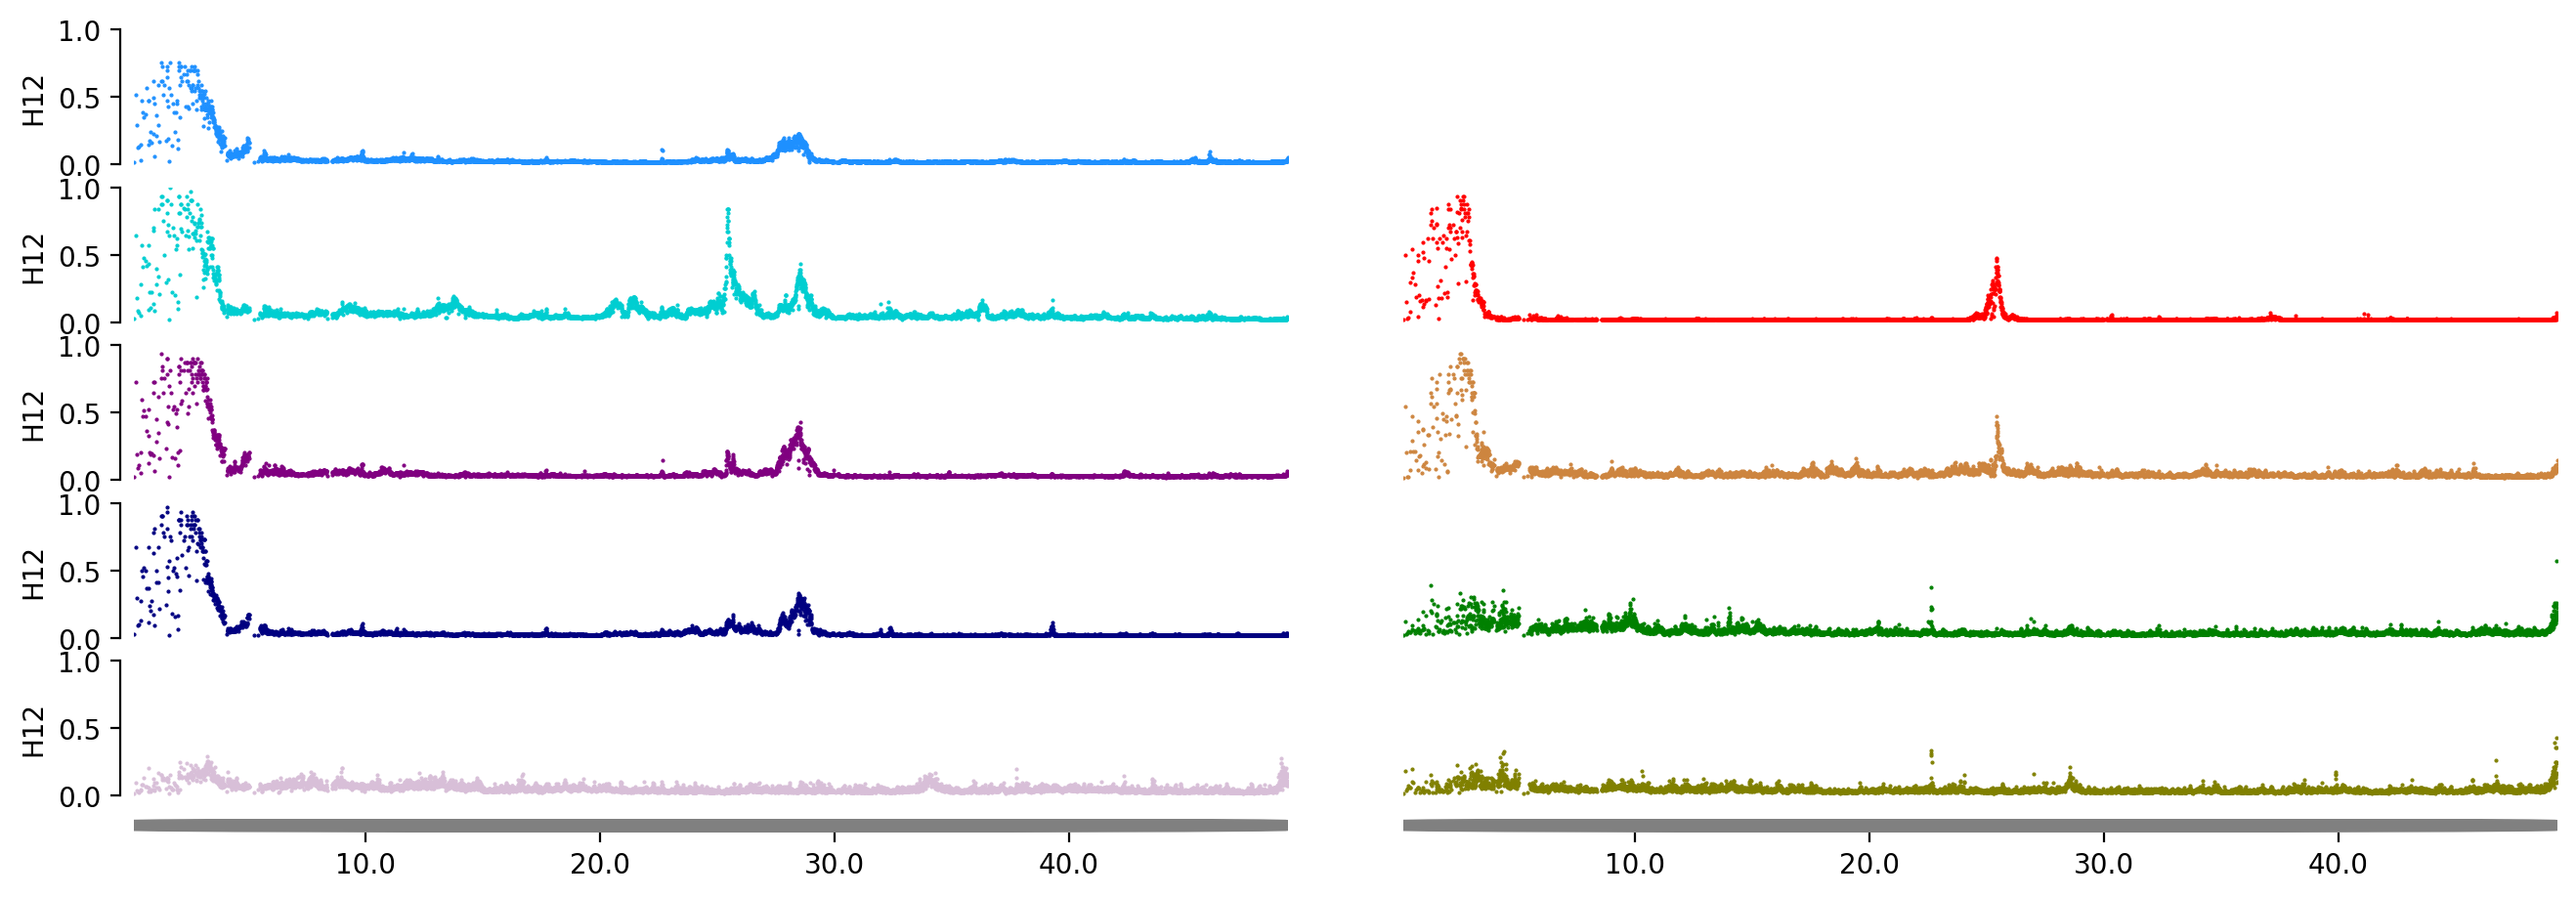

In [ ]:
fig = plt.figure(figsize=(16,12))
gs0 = gridspec.GridSpec(2, 2, wspace=0.1, hspace=0.25)

gs00 = gridspec.GridSpecFromSubplotSpec(6, 1, subplot_spec=gs0[0],height_ratios=(2,2,2,2,2,0.20))
ax1 = fig.add_subplot(gs00[0, 0])
sns.despine(ax=ax1, bottom=True, top = True, offset=5)
fig_h121(gh12_stat.pos, gh12_stat.BFA_gambiae, color=g_colors[0], ax=ax1, ylab=True)
#plt.axis('off')

ax2 = fig.add_subplot(gs00[1, 0])
sns.despine(ax=ax2, bottom=True, top = True, offset=5)
fig_h121(gh12_stat.pos, gh12_stat.GHA_gambiae,color=g_colors[1], ax=ax2, ylab=True)
#plt.axis('off')

ax3 = fig.add_subplot(gs00[2, 0])
sns.despine(ax=ax3, bottom=True, top = True, offset=5)
fig_h121(gh12_stat.pos, gh12_stat.MLI_gambiae, color=g_colors[2], ax=ax3, ylab=True)
#plt.axis('off')

ax4 = fig.add_subplot(gs00[3, 0])
sns.despine(ax=ax4, bottom=True, top = True, offset=5)
fig_h121(gh12_stat.pos, gh12_stat.GIN_gambiae, color=g_colors[3], ax=ax4, ylab=True)
#plt.axis('off')

ax5 = fig.add_subplot(gs00[4, 0])
sns.despine(ax=ax5, bottom=True, top = True, offset=5)
fig_h121(gh12_stat.pos, gh12_stat.TZA_gambiae, color=g_colors[4], ax=ax5, ylab=True)
#plt.axis('off')

ax6 = fig.add_subplot(gs00[5, 0])
fig_seq(xlim1=pos,xy=(0,0), wh=(pos[-1],0.05),boxstyle=("Round4, pad=0.1"), ax=ax6,facecolor='gray', edgecolor='gray')

####
gs01 = gridspec.GridSpecFromSubplotSpec(6, 1, subplot_spec=gs0[1],height_ratios=(2,2,2,2,2,0.2))

ax1 = fig.add_subplot(gs01[0, 0])
#fig_h121(gh12_stat.pos, gh12_stat.BFA_coluzzii, color=c_colors[0], ax=ax1, ylab=True)
plt.axis('off')

ax2 = fig.add_subplot(gs01[1, 0])
fig_h121(gh12_stat.pos, gh12_stat.BFA_coluzzii, color=c_colors[0], ax=ax2, ylab=True)
plt.axis('off')

ax3 = fig.add_subplot(gs01[2, 0])
fig_h121(gh12_stat.pos, gh12_stat.GHA_coluzzii,color=c_colors[1], ax=ax3, ylab=True)
plt.axis('off')

ax4 = fig.add_subplot(gs01[3, 0])
fig_h121(gh12_stat.pos, gh12_stat.MWI_arabiensis, color=a_colors[0], ax=ax4, ylab=True)
plt.axis('off')

ax5 = fig.add_subplot(gs01[4, 0])
fig_h121(gh12_stat.pos, gh12_stat.TZA_arabiensis, color=a_colors[1], ax=ax5, ylab=True)
plt.axis('off')

ax6 = fig.add_subplot(gs01[5, 0])
fig_seq(xlim1=pos,xy=(0,0), wh=(pos[-1],0.05),boxstyle=("Round4, pad=0.1"), ax=ax6,facecolor='gray', edgecolor='gray')


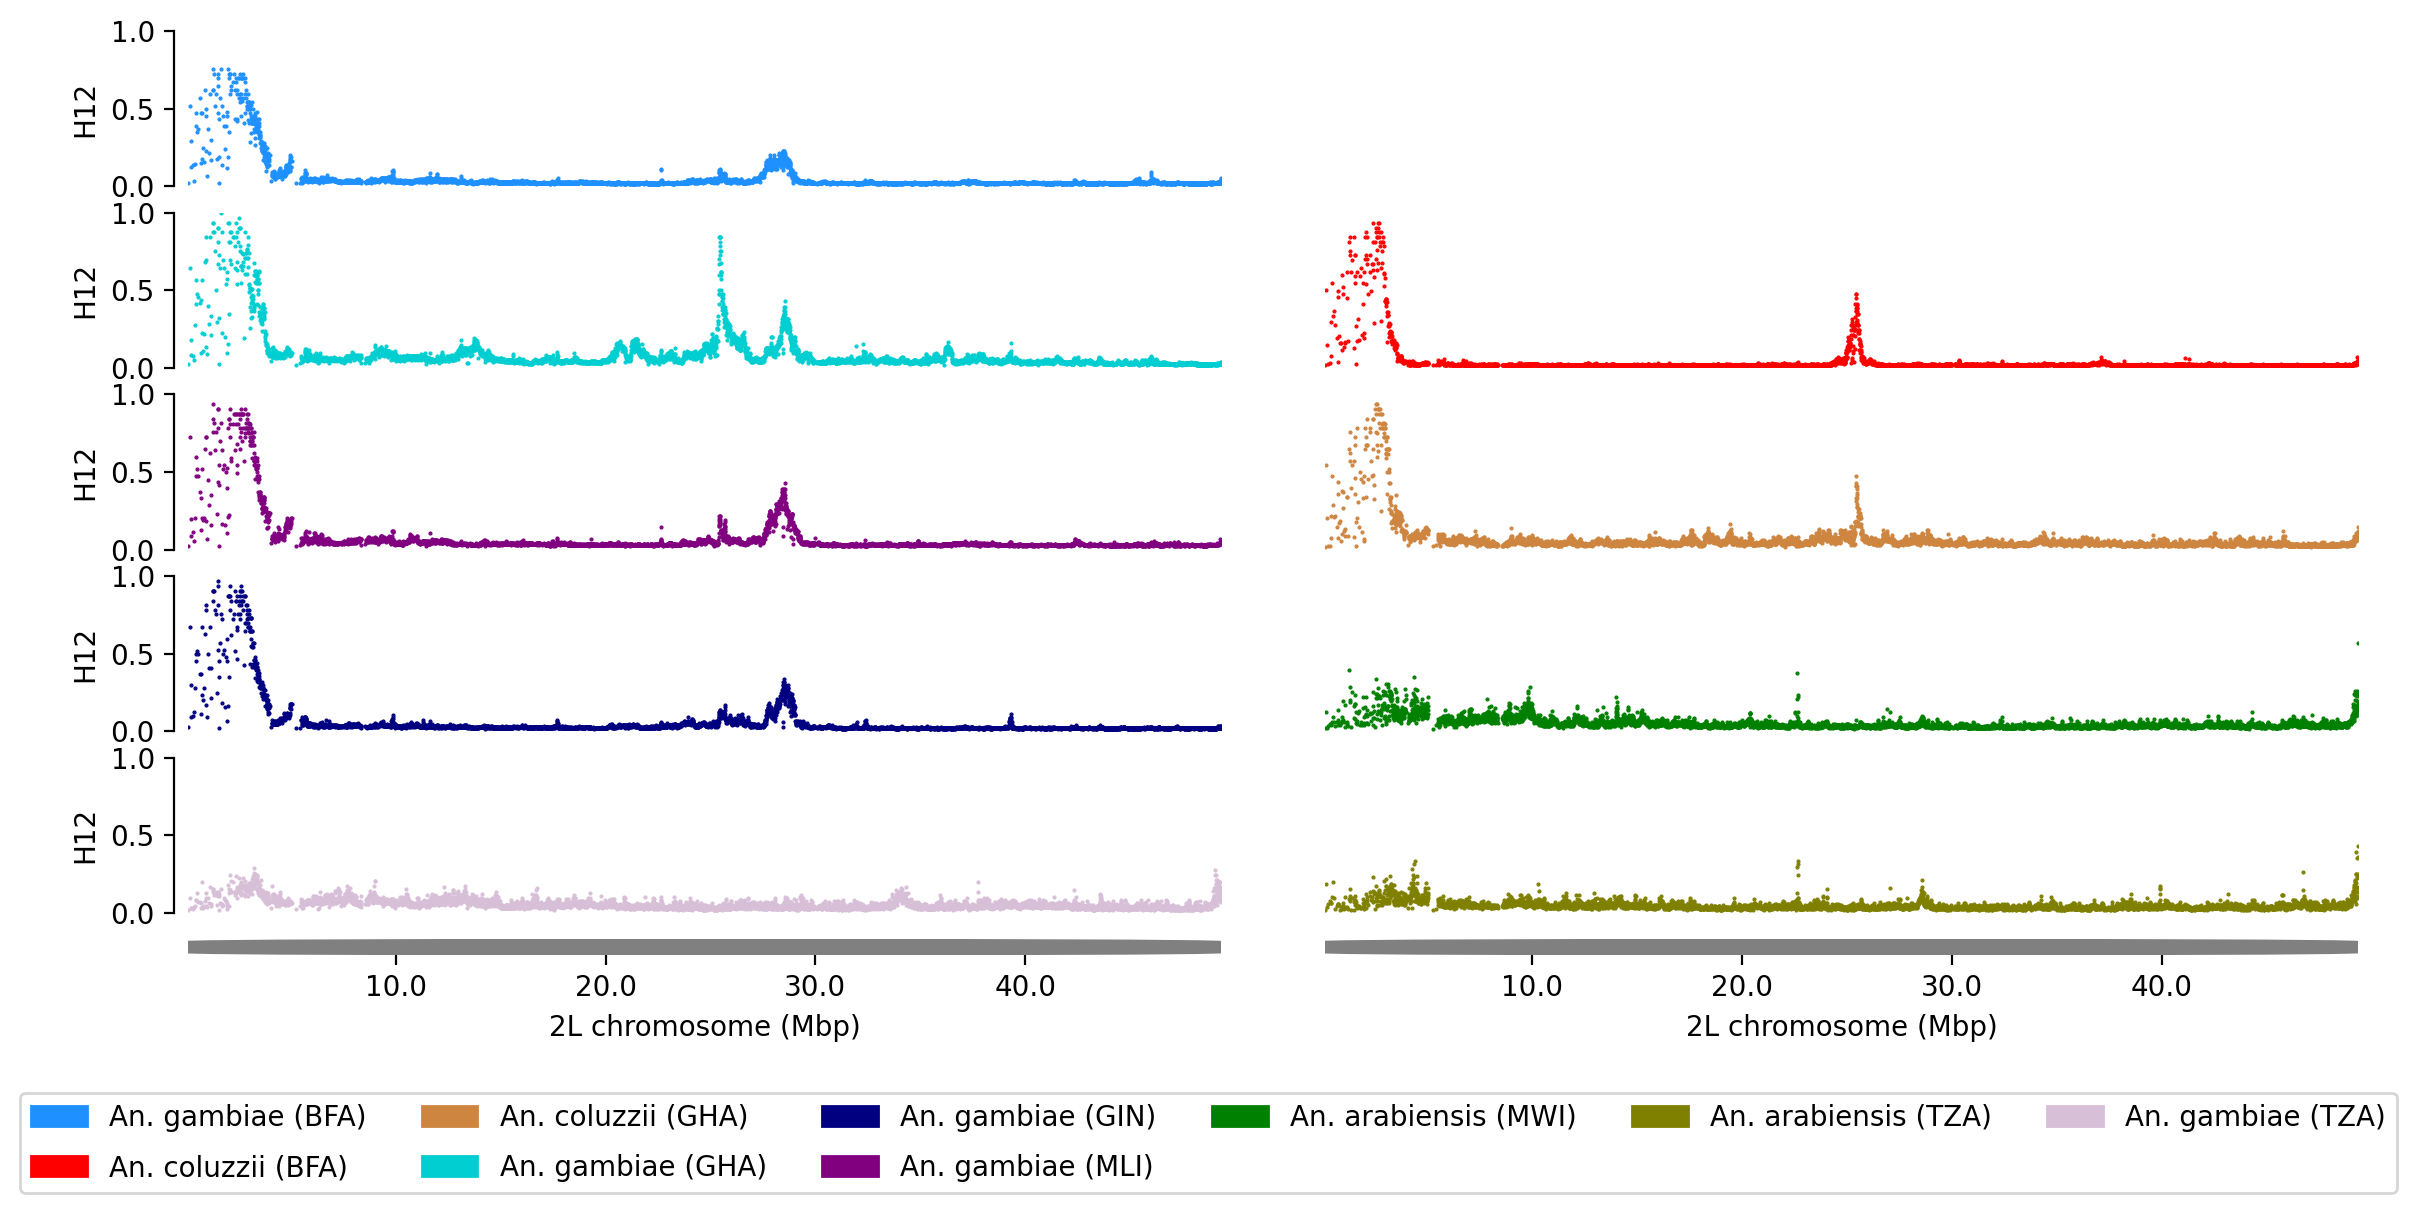

In [ ]:
## Plotting H12 multiple plot
fig = plt.figure(figsize=(14,6))
gs0 = gridspec.GridSpec(1, 2, wspace=0.1, hspace=0.25)

## right plots
gs00 = gridspec.GridSpecFromSubplotSpec(6, 1, subplot_spec=gs0[0],height_ratios=(2,2,2,2,2,0.20))
ax1 = fig.add_subplot(gs00[0, 0])
sns.despine(ax=ax1, bottom=True, top = True, offset=5)
fig_h121(gh12_stat.pos, gh12_stat.BFA_gambiae, color=g_colors[0], ax=ax1, ylab=True)
#plt.axis('off')

ax2 = fig.add_subplot(gs00[1, 0])
sns.despine(ax=ax2, bottom=True, top = True, offset=5)
fig_h121(gh12_stat.pos, gh12_stat.GHA_gambiae,color=g_colors[1], ax=ax2, ylab=True)
#plt.axis('off')

ax3 = fig.add_subplot(gs00[2, 0])
sns.despine(ax=ax3, bottom=True, top = True, offset=5)
fig_h121(gh12_stat.pos, gh12_stat.MLI_gambiae, color=g_colors[2], ax=ax3, ylab=True)
#plt.axis('off')

ax4 = fig.add_subplot(gs00[3, 0])
sns.despine(ax=ax4, bottom=True, top = True, offset=5)
fig_h121(gh12_stat.pos, gh12_stat.GIN_gambiae, color=g_colors[3], ax=ax4, ylab=True)
#plt.axis('off')

ax5 = fig.add_subplot(gs00[4, 0])
sns.despine(ax=ax5, bottom=True, top = True, offset=5)
fig_h121(gh12_stat.pos, gh12_stat.TZA_gambiae, color=g_colors[4], ax=ax5, ylab=True)
#plt.axis('off')

ax6 = fig.add_subplot(gs00[5, 0])
fig_seq(xlim1=pos,xy=(0,0), wh=(pos[-1],0.05),boxstyle=("Round4, pad=0.1"),
        ax=ax6,facecolor='gray', edgecolor='gray', xlab='2L chromosome (Mbp)')

####
gs01 = gridspec.GridSpecFromSubplotSpec(6, 1, subplot_spec=gs0[1],height_ratios=(2,2,2,2,2,0.2))

ax1 = fig.add_subplot(gs01[0, 0])
#fig_h121(gh12_stat.pos, gh12_stat.BFA_coluzzii, color=c_colors[0], ax=ax1, ylab=True)
plt.axis('off')

ax2 = fig.add_subplot(gs01[1, 0])
fig_h121(gh12_stat.pos, gh12_stat.BFA_coluzzii, color=c_colors[0], ax=ax2, ylab=True)
plt.axis('off')

ax3 = fig.add_subplot(gs01[2, 0])
fig_h121(gh12_stat.pos, gh12_stat.GHA_coluzzii,color=c_colors[1], ax=ax3, ylab=True)
plt.axis('off')

ax4 = fig.add_subplot(gs01[3, 0])
fig_h121(gh12_stat.pos, gh12_stat.MWI_arabiensis, color=a_colors[0], ax=ax4, ylab=True)
plt.axis('off')

ax5 = fig.add_subplot(gs01[4, 0])
fig_h121(gh12_stat.pos, gh12_stat.TZA_arabiensis, color=a_colors[1], ax=ax5, ylab=True)
plt.axis('off')

ax6 = fig.add_subplot(gs01[5, 0])
fig_seq(xlim1=pos,xy=(0,0), wh=(pos[-1],0.05),boxstyle=("Round4, pad=0.1"),
        ax=ax6,facecolor='gray', edgecolor='gray', xlab='2L chromosome (Mbp)')

## legend
patches = [mpl.patches.Patch(color=coh30_colors[key], label=labels[key]) for key in coh30.keys()]
fig.legend(handles=patches, loc='lower left', bbox_to_anchor=(0.06, -0.1), ncol=6, labelspacing=0.8)
#fig.legend(title='Sampling periods', labels=label_sp, handles=lines, bbox_to_anchor=(0.06, 0.8), loc='upper right',
#           borderaxespad=0,ncol=1, frameon=False, prop={'size':12, 'style': 'italic'})

fig.savefig("drive/MyDrive/analyse_Ki/savefig/h12_gamb_colu_arab.png", dpi=300, bbox_inches='tight')

In [ ]:
## genesets
genes = ['AGAP006220', 'AGAP006221','AGAP006224', 'AGAP006225', 'AGAP006226']
genesets = ag3.geneset().query('Parent in @genes')
start, stop = list(genesets.start), list(genesets.end)
starti = min(start)
stopi = max(stop)
print(starti,stopi), np.mean([starti,stopi])

28512602 28545294


(None, 28528948.0)

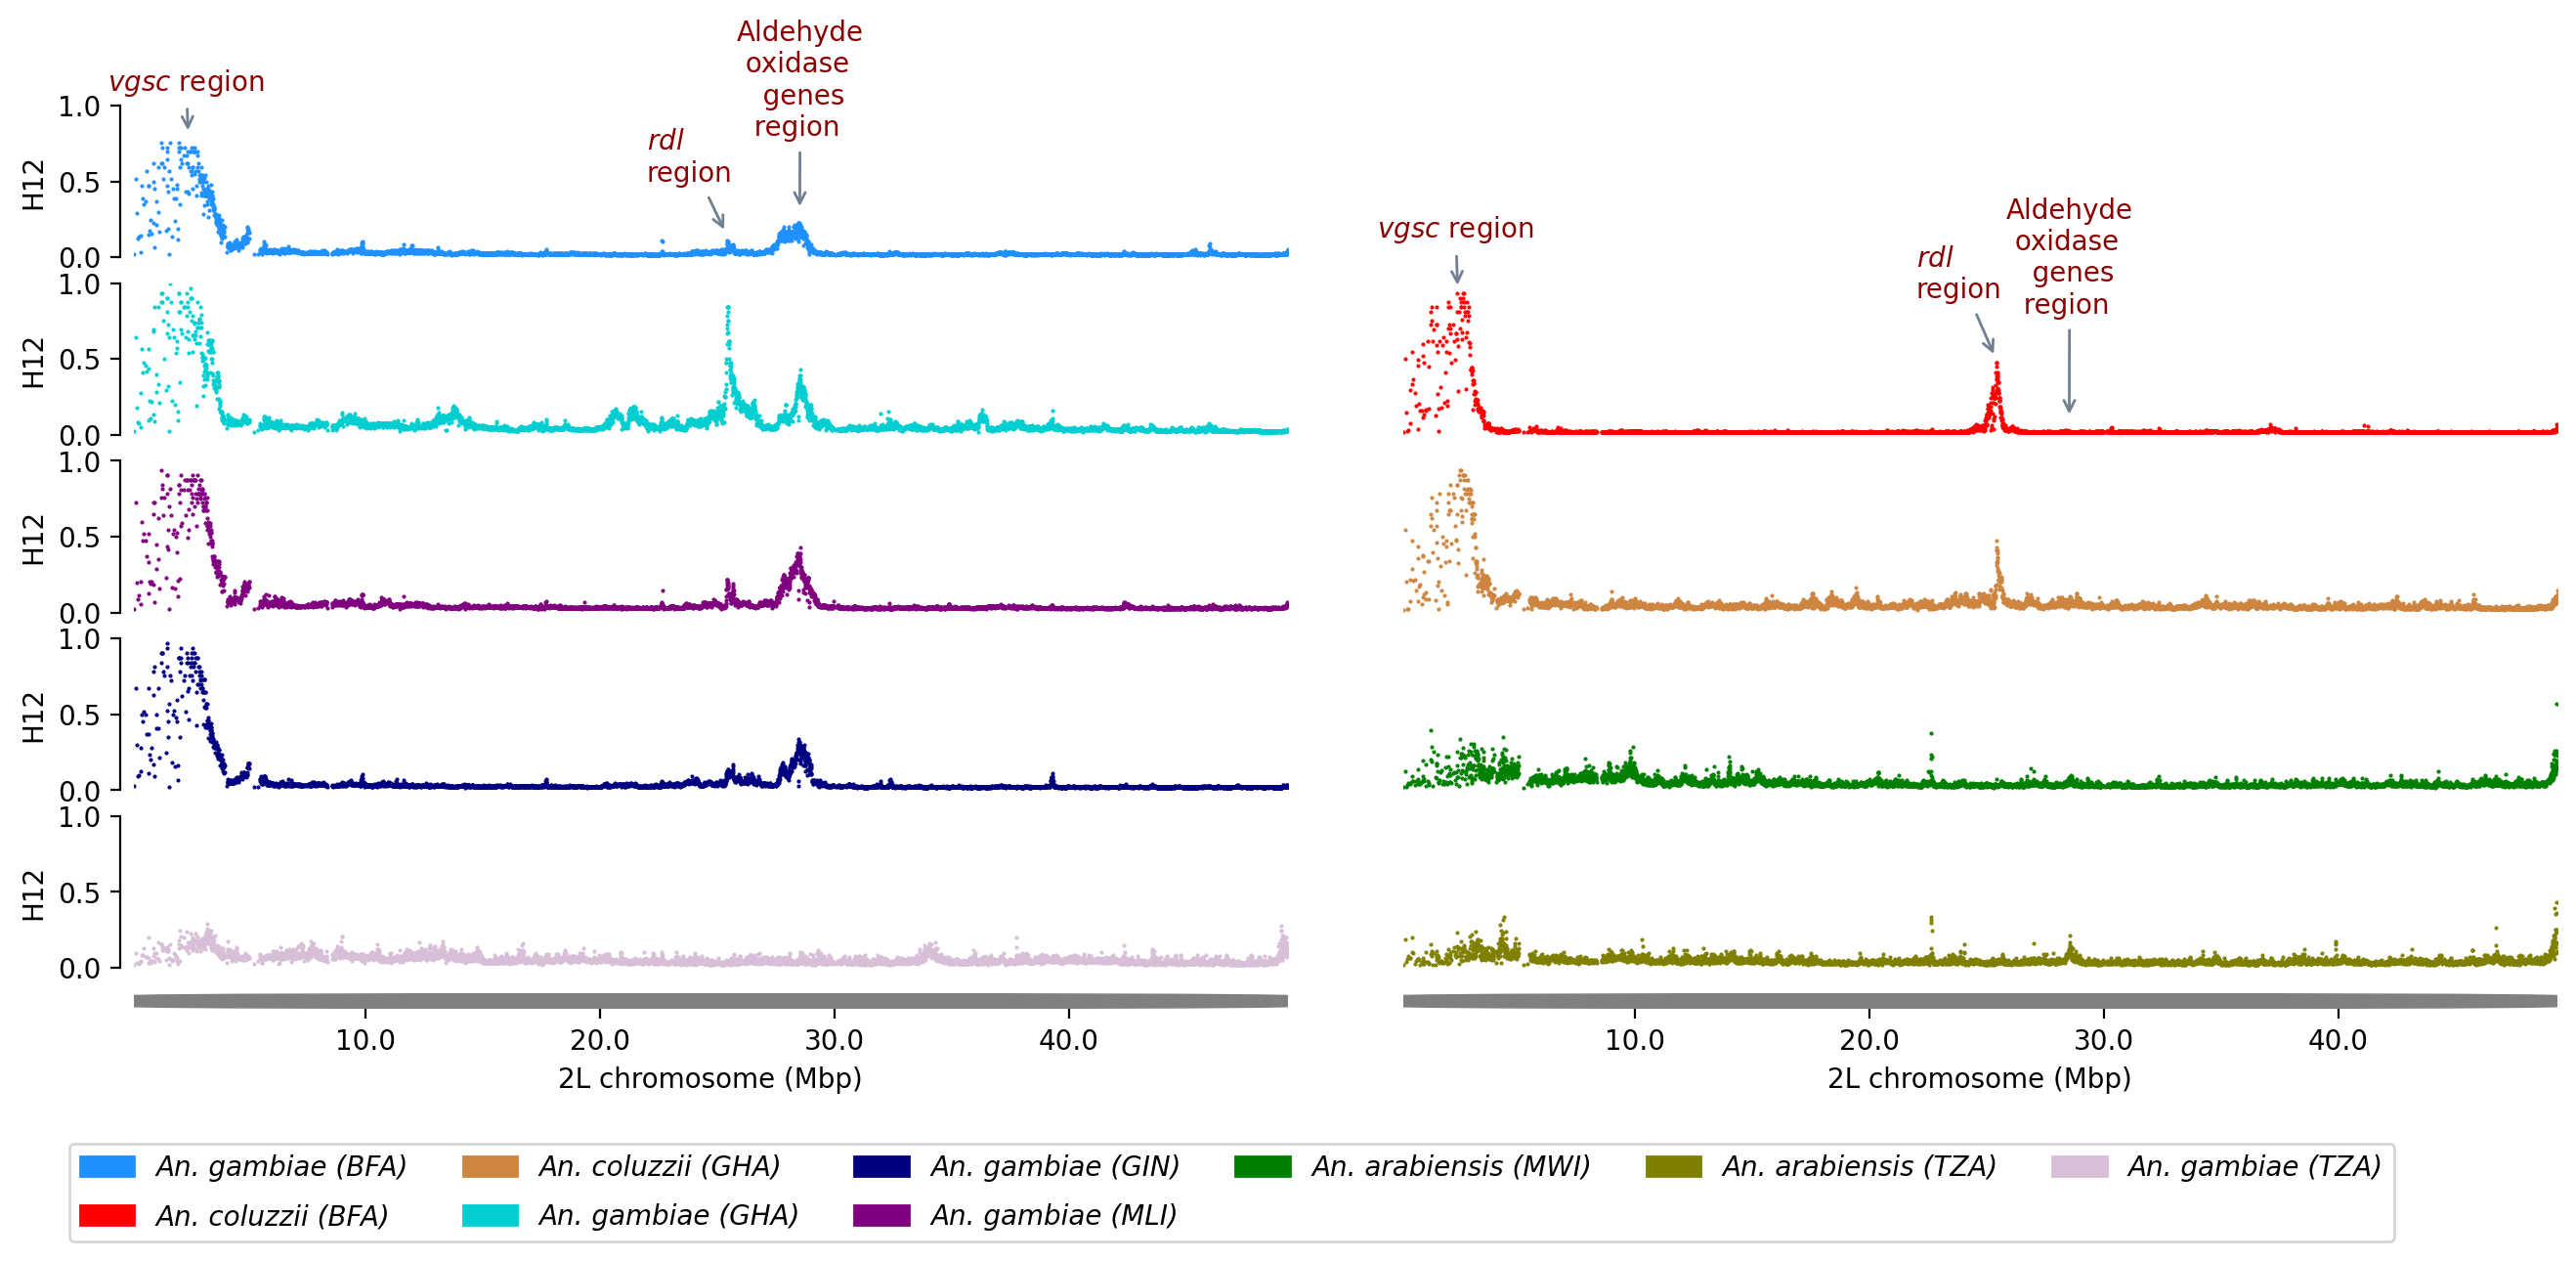

In [ ]:
## Plotting H12 multiple plot
fig = plt.figure(figsize=(16,6))
gs0 = gridspec.GridSpec(1, 2, wspace=0.1, hspace=0.25)

## right plots
gs00 = gridspec.GridSpecFromSubplotSpec(6, 1, subplot_spec=gs0[0],height_ratios=(2,2,2,2,2,0.20))
ax1 = fig.add_subplot(gs00[0, 0])
sns.despine(ax=ax1, bottom=True, top = True, offset=5)
fig_h121(gh12_stat.pos, gh12_stat.BFA_gambiae, color=g_colors[0], ax=ax1, ylab=True)

## annotate gene regions
plt.annotate('$vgsc$ region', xy=(2431617, 0.8), xytext=(-1000000, 1.1),
             color='darkred', arrowprops=dict(arrowstyle="->", color='slategrey'))
#plt.annotate('Aldehyde oxidase\n genes region', xy=(28528948.0, 0.3), xytext=(22628948, 1.1),
#             color='darkred', arrowprops=dict(arrowstyle="->", color='slategrey'))
plt.annotate('Aldehyde\n oxidase\n   genes\n  region', xy=(28528948.0, 0.3), xytext=(25828948, 0.8),
             color='darkred', arrowprops=dict(arrowstyle="->", color='slategrey'))
plt.annotate('$rdl$ \nregion', xy=(np.mean([25363652, 25434556]), 0.15), xytext=(22000000, 0.5),
             color='darkred', arrowprops=dict(arrowstyle="->", color='slategrey'))
#plt.axis('off')

ax2 = fig.add_subplot(gs00[1, 0])
sns.despine(ax=ax2, bottom=True, top = True, offset=5)
fig_h121(gh12_stat.pos, gh12_stat.GHA_gambiae,color=g_colors[1], ax=ax2, ylab=True)
#plt.axis('off')

ax3 = fig.add_subplot(gs00[2, 0])
sns.despine(ax=ax3, bottom=True, top = True, offset=5)
fig_h121(gh12_stat.pos, gh12_stat.MLI_gambiae, color=g_colors[2], ax=ax3, ylab=True)
#plt.axis('off')

ax4 = fig.add_subplot(gs00[3, 0])
sns.despine(ax=ax4, bottom=True, top = True, offset=5)
fig_h121(gh12_stat.pos, gh12_stat.GIN_gambiae, color=g_colors[3], ax=ax4, ylab=True)
#plt.axis('off')

ax5 = fig.add_subplot(gs00[4, 0])
sns.despine(ax=ax5, bottom=True, top = True, offset=5)
fig_h121(gh12_stat.pos, gh12_stat.TZA_gambiae, color=g_colors[4], ax=ax5, ylab=True)
#plt.axis('off')

ax6 = fig.add_subplot(gs00[5, 0])
fig_seq(xlim1=pos,xy=(0,0), wh=(pos[-1],0.05),boxstyle=("Round4, pad=0.1"),
        ax=ax6,facecolor='gray', edgecolor='gray', xlab='2L chromosome (Mbp)')

### left graph
gs01 = gridspec.GridSpecFromSubplotSpec(6, 1, subplot_spec=gs0[1],height_ratios=(2,2,2,2,2,0.2))

ax1 = fig.add_subplot(gs01[0, 0])
#fig_h121(gh12_stat.pos, gh12_stat.BFA_coluzzii, color=c_colors[0], ax=ax1, ylab=True)
plt.axis('off')

ax2 = fig.add_subplot(gs01[1, 0])
fig_h121(gh12_stat.pos, gh12_stat.BFA_coluzzii, color=c_colors[0], ax=ax2, ylab=True)

#annotate
plt.annotate('$vgsc$ region', xy=(2431617, 0.95), xytext=(-1000000, 1.3),
             color='darkred', arrowprops=dict(arrowstyle="->", color='slategrey'))
plt.annotate('Aldehyde\n oxidase\n   genes\n  region', xy=(28528948.0, 0.1), xytext=(25828948, 0.8),
             color='darkred', arrowprops=dict(arrowstyle="->", color='slategrey'))
plt.annotate('$rdl$ \nregion', xy=(np.mean([25363652, 25434556]), 0.5), xytext=(22000000, 0.9),
             color='darkred', arrowprops=dict(arrowstyle="->", color='slategrey'))
plt.axis('off')

ax3 = fig.add_subplot(gs01[2, 0])
fig_h121(gh12_stat.pos, gh12_stat.GHA_coluzzii,color=c_colors[1], ax=ax3, ylab=True)
plt.axis('off')

ax4 = fig.add_subplot(gs01[3, 0])
fig_h121(gh12_stat.pos, gh12_stat.MWI_arabiensis, color=a_colors[0], ax=ax4, ylab=True)
plt.axis('off')

ax5 = fig.add_subplot(gs01[4, 0])
fig_h121(gh12_stat.pos, gh12_stat.TZA_arabiensis, color=a_colors[1], ax=ax5, ylab=True)
plt.axis('off')

ax6 = fig.add_subplot(gs01[5, 0])
fig_seq(xlim1=pos,xy=(0,0), wh=(pos[-1],0.05),boxstyle=("Round4, pad=0.1"),
        ax=ax6,facecolor='gray', edgecolor='gray', xlab='2L chromosome (Mbp)')

## legend
patches = [mpl.patches.Patch(color=coh30_colors[key], label=labels[key]) for key in coh30.keys()]
fig.legend(handles=patches, loc='lower left', bbox_to_anchor=(0.1, -0.1), ncol=6,
           prop={'size':10, 'style': 'italic'}, labelspacing=0.8)
#fig.legend(title='Sampling periods', labels=label_sp, handles=lines, bbox_to_anchor=(0.06, 0.8), loc='upper right',
#           borderaxespad=0,ncol=1, frameon=False, prop={'size':12, 'style': 'italic'})

fig.savefig("drive/MyDrive/analyse_Ki/savefig/fig_h12_gamb_colu_arab.png", dpi=300, bbox_inches='tight')

In [ ]:
sample_sets=["AG1000G-GN-A", "AG1000G-GN-B"]

In [ ]:
ag3.plot_h12_gwss(
    contig="2L",
    analysis="gamb_colu",
    window_size=1000,
    sample_sets=sample_sets,
    sample_query="taxon =='gambiae'",
)